# Modeling #

## Import APIs ##

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import wfdb
import ast

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data ##

In [4]:
ptbxl_data = pd.read_csv('./cleaned_data/cleaned_ptbxl_metadata.csv', index_col='ecg_id')
normal_data = ptbxl_data[ptbxl_data['diagnostic_superclass'] == 'NORMAL']
abnormal_data = ptbxl_data[ptbxl_data['diagnostic_superclass'] == 'ABNORMAL']

### Metadata ###

In [5]:
normal_metadata = normal_data.loc[:, ['age', 'sex', 'device', 'validated_by_human']].copy()
abnormal_metadata = abnormal_data.loc[:, ['age', 'sex', 'device', 'validated_by_human']].copy()
print(f'Normal metadata shape: {normal_metadata.shape}')
print(f'Abnormal metadata shape: {abnormal_metadata.shape}')

Normal metadata shape: (9069, 4)
Abnormal metadata shape: (9069, 4)


### ECG Waveform data ###

In [6]:
def extract_ecg_data(data):
    new_data = []
    for idx in data.index:
        record_path = data.loc[idx]['filename_hr']
        waveform_df = pd.read_csv('./cleaned_data/waveform_data/' + record_path + '.csv', index_col='Time (s)')
        new_data.append(waveform_df)
    new_data = np.array(new_data)
    return new_data

In [7]:
normal_ecg_data = extract_ecg_data(normal_data)
abnormal_ecg_data = extract_ecg_data(abnormal_data)
print(f'Normal ECG data shape: {normal_ecg_data.shape}')
print(f'Abnormal ECG data shape: {abnormal_ecg_data.shape}')

Normal ECG data shape: (9069, 1000, 12)
Abnormal ECG data shape: (9069, 1000, 12)


In [45]:
#np.save("./cleaned_data/normal_ecg_data.npy", normal_ecg_data)
#np.save("./cleaned_data/abnormal_ecg_data.npy", abnormal_ecg_data)

In [7]:
normal_ecg_data = np.load("./cleaned_data/normal_ecg_data.npy")
abnormal_ecg_data = np.load("./cleaned_data/abnormal_ecg_data.npy")

## Train-test split ##

This recommended train-test split code was obtained from the downloaded folder with the dataset: https://physionet.org/content/ptb-xl/1.0.3/.

In [9]:
split_idx = int(normal_data.shape[0] * 0.8)

normal_ecg_train = normal_ecg_data[0:split_idx]
normal_ecg_test = normal_ecg_data[split_idx:]
print(f'Normal ECG train shape: {normal_ecg_train.shape}')
print(f'Normal ECG test shape: {normal_ecg_test.shape}')

abnormal_ecg_train = abnormal_ecg_data[0:split_idx]
abnormal_ecg_test = abnormal_ecg_data[split_idx:]
print(f'Abnormal ECG train shape: {abnormal_ecg_train.shape}')
print(f'Abnormal ECG test shape: {abnormal_ecg_test.shape}')

normal_metadata_train = normal_metadata[0:split_idx]
normal_metadata_test = normal_metadata[split_idx:]
print(f'Normal metadata train shape: {normal_metadata_train.shape}')
print(f'Normal metadata test shape: {normal_metadata_test.shape}')

abnormal_metadata_train = abnormal_metadata[0:split_idx]
abnormal_metadata_test = abnormal_metadata[split_idx:]
print(f'Abnormal metadata train shape: {abnormal_metadata_train.shape}')
print(f'Abnormal metadata test shape: {abnormal_metadata_test.shape}')

Normal ECG train shape: (7255, 1000, 12)
Normal ECG test shape: (1814, 1000, 12)
Abnormal ECG train shape: (7255, 1000, 12)
Abnormal ECG test shape: (1814, 1000, 12)
Normal metadata train shape: (7255, 4)
Normal metadata test shape: (1814, 4)
Abnormal metadata train shape: (7255, 4)
Abnormal metadata test shape: (1814, 4)


## Normalize ECG waveform data ##

In [10]:
def normalize_waveform(data):
    # Code generated from Bing Copilot
    normalized_data = np.empty_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            min_val = np.min(data[i, :, j])
            max_val = np.max(data[i, :, j])

            if max_val == min_val:
                normalized_data[i, :, j] = 0
            else:
                normalized_data[i, :, j] = (data[i, :, j] - min_val) / (max_val - min_val)
    return normalized_data

In [11]:
# Since normalization occurs only within each record, there will be no contamination from train data
std_normal_ecg_train = normalize_waveform(normal_ecg_train)
std_normal_ecg_test = normalize_waveform(normal_ecg_test)

std_abnormal_ecg_train = normalize_waveform(abnormal_ecg_train)
std_abnormal_ecg_test = normalize_waveform(abnormal_ecg_test)

## Normalize and one-hot encode metadata ##

In [12]:
# Code generated from ChatGPT
scaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

encoder_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

normal_preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_transformer, ['age']),
        ('cat', encoder_transformer, ['sex', 'device', 'validated_by_human'])
    ])

std_normal_metadata_train = normal_preprocessor.fit_transform(normal_metadata_train).toarray()
std_normal_metadata_test = normal_preprocessor.transform(normal_metadata_test).toarray()

In [13]:
scaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

encoder_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

abnormal_preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_transformer, ['age']),
        ('cat', encoder_transformer, ['sex', 'device', 'validated_by_human'])
    ])

std_abnormal_metadata_train = abnormal_preprocessor.fit_transform(abnormal_metadata_train).toarray()
std_abnormal_metadata_test = abnormal_preprocessor.transform(abnormal_metadata_test).toarray()

## Initialize Autoencoder Dataloaders ##

In [14]:
autoencoder_ecg_train_set = torch.from_numpy(std_normal_ecg_train).float()
autoencoder_metadata_train_set = torch.from_numpy(std_normal_metadata_train).float()

normal_ecg_test_set = torch.from_numpy(std_normal_ecg_test).float()
normal_metadata_test_set = torch.from_numpy(std_normal_metadata_test).float()

In [15]:
batch_size = 32

autoencoder_train_dataset = TensorDataset(autoencoder_ecg_train_set, autoencoder_metadata_train_set)
autoencoder_train_loader = DataLoader(autoencoder_train_dataset, batch_size=batch_size, shuffle=True)

autoencoder_test_dataset = TensorDataset(normal_ecg_test_set, normal_metadata_test_set)
autoencoder_test_loader = DataLoader(autoencoder_test_dataset, batch_size=batch_size, shuffle=True)

## CNN autoencoder + LSTM metadata model ##

In [75]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=12,
                      out_channels=32,
                      kernel_size=4,
                      stride=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=32,
                               out_channels=12,
                               kernel_size=4,
                               stride=1),
            nn.Sigmoid(),
            nn.Upsample(1000)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        encoded_output = self.encoder(x)
        decoded_output = self.decoder(encoded_output)
        return decoded_output.permute(0, 2, 1)

In [76]:
class MetadataLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(16, 32, batch_first=True)
        self.output_layer = nn.Linear(32, 12)
    
    def forward(self, x, h):
        lstm_outputs, h_n = self.lstm(x, h)
        outputs = self.output_layer(lstm_outputs.squeeze(dim=1))
        return outputs, h_n

In [77]:
class CombinedModel(nn.Module):
    def __init__(self, cnn_autoencoder, lstm_model):
        super().__init__()
        self.cnn_autoencoder = cnn_autoencoder
        self.lstm_model = lstm_model
        self.fc = nn.Linear(24, 12)
        
    def forward(self, ecg_data, metadata, hc):
        cnn_output = self.cnn_autoencoder(ecg_data)
        lstm_output, hc_n = self.lstm_model(metadata, hc)
        reshaped_lstm_output = lstm_output.unsqueeze(1).repeat(1, 1000, 1)
        combined_output = torch.cat((cnn_output, reshaped_lstm_output), dim=-1)
        output = self.fc(combined_output)

        return output, hc_n

### Training ###

In [78]:
cnn_autoencoder_model = CNNAutoencoder()
lstm_metadata_model = MetadataLSTM()

combinedModel = CombinedModel(cnn_autoencoder_model, lstm_metadata_model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combinedModel.parameters(), lr=1e-3)

combinedModel.to(device)

CombinedModel(
  (cnn_autoencoder): CNNAutoencoder(
    (encoder): Sequential(
      (0): Conv1d(12, 32, kernel_size=(4,), stride=(1,))
      (1): ReLU()
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(32, 12, kernel_size=(4,), stride=(1,))
      (1): Sigmoid()
      (2): Upsample(size=1000, mode='nearest')
    )
  )
  (lstm_model): MetadataLSTM(
    (lstm): LSTM(16, 32, batch_first=True)
    (output_layer): Linear(in_features=32, out_features=12, bias=True)
  )
  (fc): Linear(in_features=24, out_features=12, bias=True)
)

In [79]:
def train_combined(model, train_loader, criterion, optimizer, nepoch=20):
    for epoch in range(nepoch):
        num_layers = model.lstm_model.lstm.num_layers
        hidden_size = model.lstm_model.lstm.hidden_size
        h_0 = torch.zeros(num_layers, hidden_size).to(device)
        c_0 = torch.zeros(num_layers, hidden_size).to(device)
        for batch_ecg, batch_metadata in train_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            
            optimizer.zero_grad()
            reconstructed_data, (h_n, c_n) = model(ecg_data, metadata, (h_0, c_0))
            loss = criterion(reconstructed_data, ecg_data)
            loss.backward()
            optimizer.step()
        
        print(f"Epoch [{epoch+1}/{nepoch}], Loss: {loss.item()}")
            

In [80]:
# Train the model
train_combined(combinedModel, autoencoder_train_loader, criterion, optimizer)

Epoch [1/20], Loss: 0.013082781806588173
Epoch [2/20], Loss: 0.00575968436896801
Epoch [3/20], Loss: 0.003965556621551514
Epoch [4/20], Loss: 0.0035343982744961977
Epoch [5/20], Loss: 0.003389982972294092
Epoch [6/20], Loss: 0.0021308530122041702
Epoch [7/20], Loss: 0.0017447719583287835
Epoch [8/20], Loss: 0.001860011019743979
Epoch [9/20], Loss: 0.001227906090207398
Epoch [10/20], Loss: 0.0010648757452145219
Epoch [11/20], Loss: 0.0008713697316125035
Epoch [12/20], Loss: 0.0007780295563861728
Epoch [13/20], Loss: 0.0006158737232908607
Epoch [14/20], Loss: 0.0007674531661905348
Epoch [15/20], Loss: 0.0007034057634882629
Epoch [16/20], Loss: 0.0007193921483121812
Epoch [17/20], Loss: 0.00044939841609448195
Epoch [18/20], Loss: 0.0003900708688888699
Epoch [19/20], Loss: 0.00041036002221517265
Epoch [20/20], Loss: 0.00043312611524015665


In [81]:
torch.save(combinedModel.state_dict(), "./models/combinedModel.pth")

### Testing ###

In [115]:
def test_model(model, test_loader, criterion):
    num_layers = model.lstm_model.lstm.num_layers
    hidden_size = model.lstm_model.lstm.hidden_size
    h_0 = torch.zeros(num_layers, hidden_size).to(device)
    c_0 = torch.zeros(num_layers, hidden_size).to(device)
    
    errors = []
    for batch_ecg, batch_metadata in test_loader:
        ecg_data = batch_ecg.to(device).float()
        metadata = batch_metadata.to(device).float()
        reconstructed_data, (h_n, c_n) = model(ecg_data, metadata, (h_0, c_0))
        loss = criterion(reconstructed_data, ecg_data)
        errors.append(loss.item())
    
    avg_error = sum(errors) / len(test_loader)
    threshold = np.percentile(errors, 99)
    return avg_error, threshold

In [117]:
criterion = nn.MSELoss()
reconstruction_error, threshold = test_model(combinedModel, autoencoder_test_loader, criterion)
print(f'Reconstruction error on test data: {reconstruction_error}')
print(f'Threshold based on 99th percentile of errors: {threshold}')

Reconstruction error on test data: 0.00034853985855813353
Threshold based on 99th percentile of errors: 0.000491803006734699


### Visualization ###

In [118]:
def detect_anomalies(original_ecg, reconstructed_ecg, criterion):
    reconstruction_errors = criterion(original_ecg, reconstructed_ecg)
    anomalies = np.where(reconstruction_errors > threshold)
    return anomalies

In [121]:
def visualize(model, ecg_input, metadata_input, criterion):
    lead_vals = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    time = np.arange(0, 1000) / 100
    model.eval()
    with torch.no_grad():
        num_layers = model.lstm_model.lstm.num_layers
        hidden_size = model.lstm_model.lstm.hidden_size
        h_0 = torch.zeros(num_layers, hidden_size).to(device)
        c_0 = torch.zeros(num_layers, hidden_size).to(device)
    
    num_layers = model.lstm_model.lstm.num_layers
    hidden_size = model.lstm_model.lstm.hidden_size
    h_0 = torch.zeros(num_layers, hidden_size).to(device)
    c_0 = torch.zeros(num_layers, hidden_size).to(device)
    
    prediction, _ = model(ecg_input, metadata_input, (h_0, c_0))
    fig, axs = plt.subplots(6, 2, figsize=(15, 20))
    for i in range(6):
        for j in range(2):
            lead_idx = i * 2 + j
            lead_val = lead_vals[lead_idx]
            
            original_ecg = ecg_input[0, :, lead_idx]
            reconstructed_ecg = prediction[0, :, lead_idx]
            anomalies = detect_anomalies(original_ecg, reconstructed_ecg, criterion)
            
            axs[i, j].scatter(time[anomalies], original_ecg[anomalies], color='red', label='Anomalies')
            axs[i, j].plot(time, original_ecg.detach().numpy(), label='Original')
#             axs[i, j].plot(time, reconstructed_ecg.detach().numpy(), label='Reconstructed')
            axs[i, j].set_xlabel('Time (s)')
            axs[i, j].set_ylabel('Normalized ECG Reading')
            axs[i, j].set_title(f'Lead {lead_val}')
            axs[i, j].legend()
    plt.tight_layout()
    plt.show()

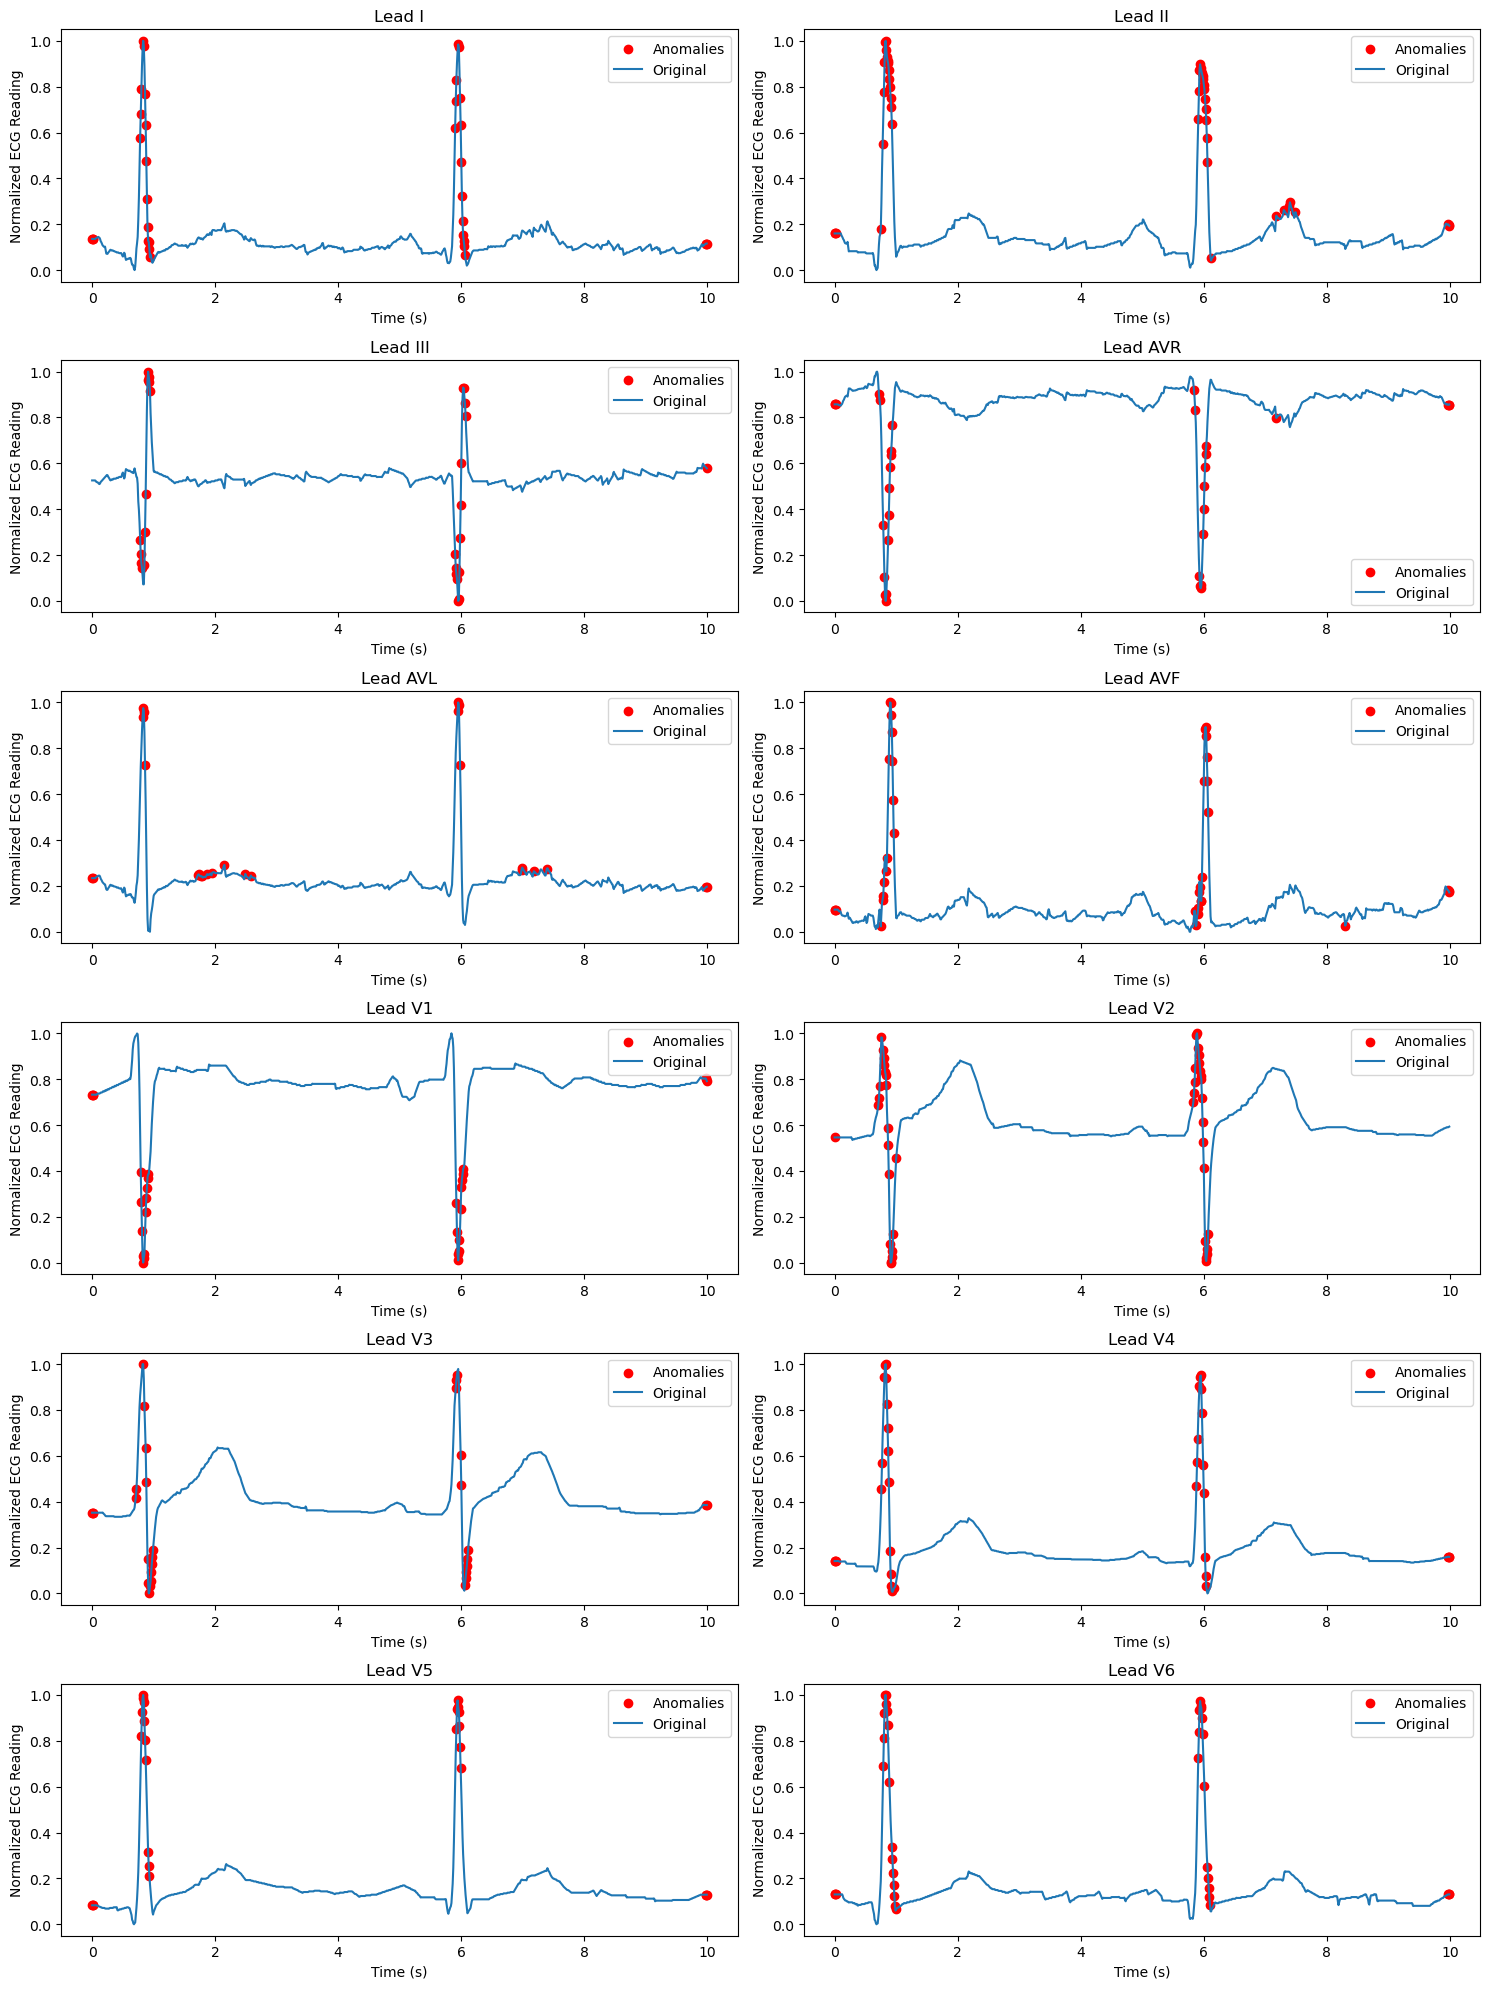

In [122]:
criterion = nn.MSELoss(reduction='none')
for batch_ecg, batch_metadata in autoencoder_test_loader:
    ecg_data = batch_ecg.to(device).float()
    batch_metadata = batch_metadata.to(device).float()
    
    single_ecg_data = ecg_data[0].unsqueeze(0)
    single_metadata = batch_metadata[0].unsqueeze(0)
    break

visualize(combinedModel, single_ecg_data, single_metadata, criterion)

# Computational Experiment #1: Transfer Learning #

# Computational Experiment #2:  TCN Autoencoder #

Model Card for the Hybrid Autoencoder Model Name: Hybrid Autoencoder for ECG and Metadata

Description: This model is designed to learn compressed representations of combined ECG waveform and patient metadata. It utilizes separate pathways for waveform data and metadata, merging them into a dense representation which is then used to reconstruct both types of data.

Model Architecture:

Waveform Pathway: Convolutional layers followed by pooling and flattening. Metadata Pathway: Dense layers. Combined Encoding and Decoding: Dense layers. Intended Use: Intended for anomaly detection in ECG data where additional patient metadata is available and considered relevant.

Data Used for Training: Assumes a dataset comprising ECG waveform data aligned with patient metadata such as age, sex, and device information.

Limitations: The model's effectiveness is highly dependent on the quality and preprocessing of the input data. The architecture needs fine-tuning and validation using real-world data to ensure robustness.

Ethical Considerations: Care should be taken to avoid biases that may arise from imbalanced data across different demographic groups. Privacy concerns should be addressed when handling patient data.

This framework sets up the foundation of your model; further tuning, training, and validation steps are needed to adapt it to specific tasks or datasets.

In [57]:
num_unique_devices = ptbxl_data['device'].nunique()
print(f"Number of unique devices: {num_unique_devices}")

Number of unique devices: 11


In [15]:
from pytorch_tcn import TCN
num_unique_devices = ptbxl_data['device'].nunique()
class TCNAutoencoder(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size, dropout, metadata_dims):
        super(TCNAutoencoder, self).__init__()
        self.encoder = TCN(
            num_inputs=num_inputs,
            num_channels=num_channels,
            kernel_size=kernel_size,
            dropout=dropout,
            causal=True,
        )
        self.age_embedding = nn.Linear(1, metadata_dims[0])  # Age is a single value
        self.sex_embedding = nn.Linear(2, metadata_dims[1])  # Sex is one-hot encoded (2 columns)
        self.device_embedding = nn.Linear(num_unique_devices, metadata_dims[2]) #one hot (11 cols)
        self.validated_embedding = nn.Linear(2, metadata_dims[3]) #one hot (2 cols)
        
        decoder_input_dim = num_channels[-1] + sum(metadata_dims)
        self.decoder = TCN(
            num_inputs=decoder_input_dim,
            num_channels=num_channels[::-1],
            kernel_size=kernel_size,
            dropout=dropout,    
            causal=True,
            output_projection=num_inputs,
        )
        
    def forward(self, x, metadata):
        encoded = self.encoder(x)
        
        age_emb = self.age_embedding(metadata[:, 0].unsqueeze(1))
        sex_emb = self.sex_embedding(metadata[:, 1:3])
        device_emb = self.device_embedding(metadata[:, 3:-2])
        validated_emb = self.validated_embedding(metadata[:, -2:])
        
        metadata_emb = torch.cat([age_emb, sex_emb, device_emb, validated_emb], dim=-1)
        metadata_emb = metadata_emb.unsqueeze(2).expand(-1, -1, encoded.size(2))
        
        concatenated = torch.cat([encoded, metadata_emb], dim=1)
        decoded = self.decoder(concatenated)
        return decoded

In [59]:
batch_size = 32
num_inputs = 12  # Assuming 12 input channels in the ECG data
num_channels = [32, 64, 128]  # Example number of channels in each residual block of the encoder
kernel_size = 3  # Example kernel size for the TCN layers
dropout = 0.2  # Example dropout rate
metadata_dims = [10, 5, 20, 5]  # Example embedding dimensions for age, sex, and device, and validated

print(std_abnormal_metadata_train.shape)
assert num_unique_devices == std_abnormal_metadata_train.shape[1] - 5, "Number of unique devices should match the number of device columns in metadata"

model = TCNAutoencoder(num_inputs, num_channels, kernel_size, dropout, metadata_dims)

model.to(device)

#train_dataset = TensorDataset(torch.from_numpy(normalized_waveform_train).float(), torch.from_numpy(normalized_metadata_train))
#train_loader = DataLoader(wave, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

(7255, 16)


In [60]:
for epoch in range(num_epochs):
    for batch_data, batch_metadata in autoencoder_train_loader:
        ecg_data = batch_data.to(device).permute(0, 2, 1).float()
        batch_metadata = batch_metadata.to(device).float()
        
        optimizer.zero_grad()
        reconstructed_data = model(ecg_data, batch_metadata)
        loss = criterion(reconstructed_data, ecg_data)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0032
Epoch [2/10], Loss: 0.0007
Epoch [3/10], Loss: 0.0004
Epoch [4/10], Loss: 0.0002
Epoch [5/10], Loss: 0.0002
Epoch [6/10], Loss: 0.0001
Epoch [7/10], Loss: 0.0002
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0001


In [61]:
torch.save(model.state_dict(), "./models/tcn.pth")
print(f"Model saved")

Model saved


In [16]:
#reinit model
batch_size = 32
num_inputs = 12  # Assuming 12 input channels in the ECG data
num_channels = [32, 64, 128]  # Example number of channels in each residual block of the encoder
kernel_size = 3  # Example kernel size for the TCN layers
dropout = 0.2  # Example dropout rate
metadata_dims = [10, 5, 20, 5]  # Example embedding dimensions for age, sex, and device, and validated

model = TCNAutoencoder(num_inputs, num_channels, kernel_size, dropout, metadata_dims)
model.load_state_dict(torch.load("./models/tcn.pth"))
model.to(device)

criterion = nn.MSELoss()

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_data, batch_metadata in test_loader:
            ecg_data = batch_data.to(device).permute(0, 2, 1).float()
            batch_metadata = batch_metadata.to(device).float()
            reconstructed_data = model(ecg_data, batch_metadata)
            loss = criterion(reconstructed_data, ecg_data)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")



In [17]:
test(model, autoencoder_test_loader, criterion)

Test Loss: 0.0001


In [23]:
def visualize_predictions_tcn(model, ecg_input, metadata_input):
    lead_vals = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    time = np.arange(0, ecg_input.shape[1]) / 100  # Assuming a sampling rate of 100 Hz

    model.eval()
    with torch.no_grad():
        ecg_input = ecg_input.permute(0, 2, 1).float().to(device)  # Reshape input to (batch_size, num_channels, seq_length)
        metadata_input = metadata_input.float().to(device)
        prediction = model(ecg_input, metadata_input)
        prediction = prediction.permute(0, 2, 1)  # Reshape output to (batch_size, seq_length, num_channels)

    fig, axs = plt.subplots(6, 2, figsize=(15, 20))
    for i in range(6):
        for j in range(2):
            lead_idx = i * 2 + j
            lead_val = lead_vals[lead_idx]
            original_ecg = ecg_input[0, lead_idx, :].cpu().numpy()
            reconstructed_ecg = prediction[0, :, lead_idx].cpu().numpy()
            axs[i, j].plot(time, original_ecg, label='Original')
            axs[i, j].plot(time, reconstructed_ecg, label='Reconstructed')
            axs[i, j].set_xlabel('Time (s)')
            axs[i, j].set_ylabel('Normalized ECG Reading')
            axs[i, j].set_title(f'Lead {lead_val}')
            axs[i, j].legend()

    plt.tight_layout()
    plt.show()

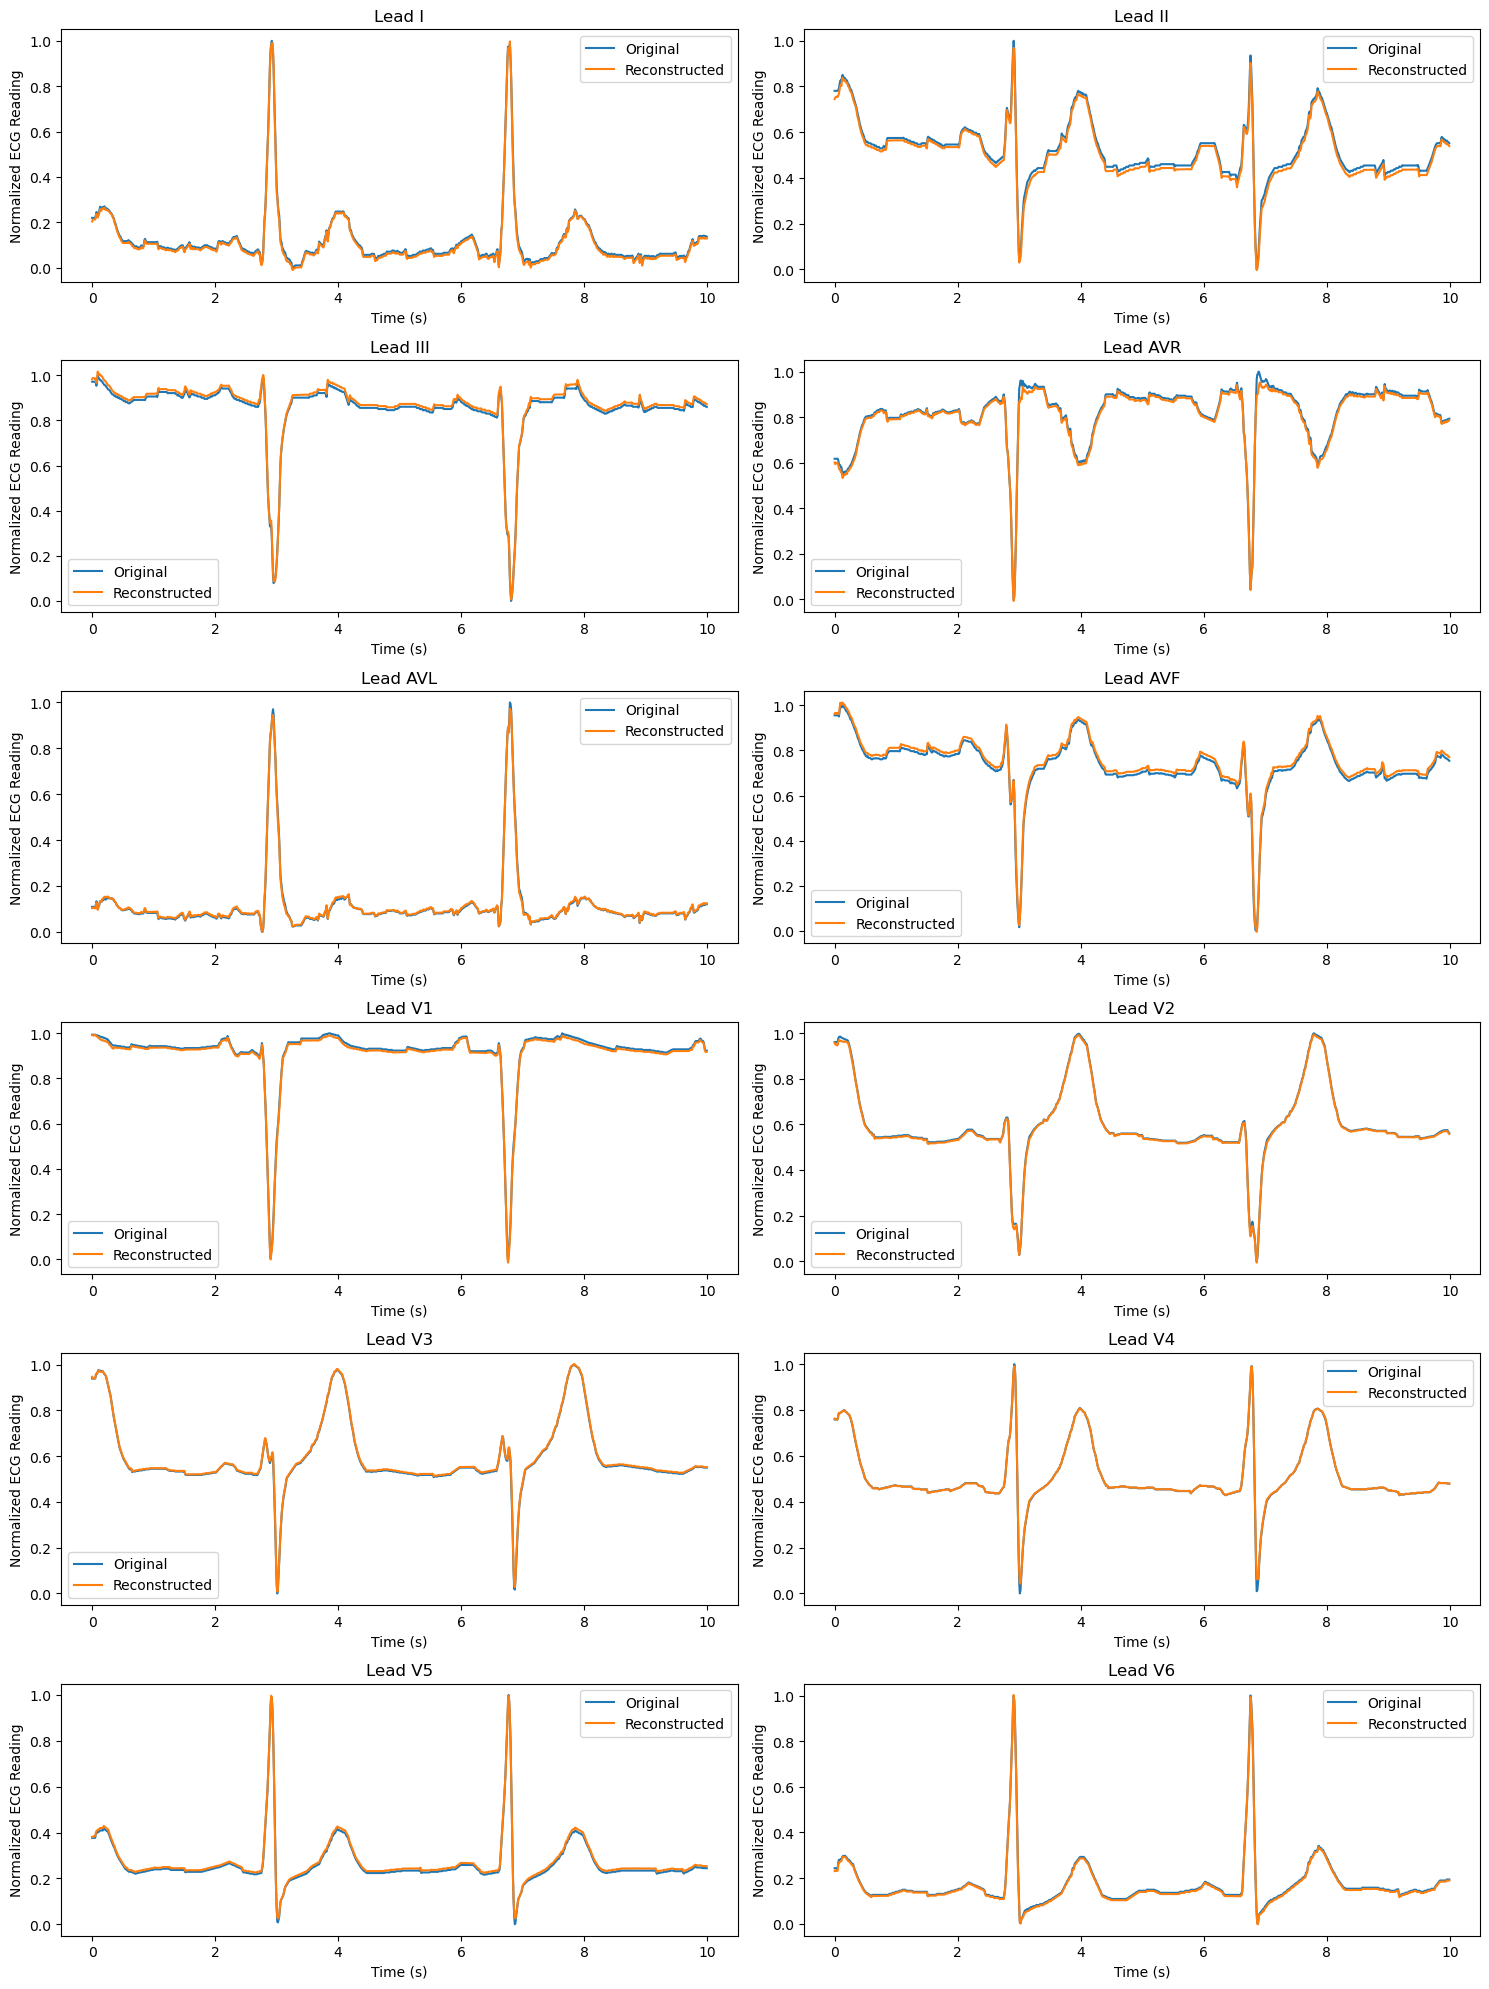

In [24]:
for batch_data, batch_metadata in autoencoder_test_loader:
    ecg_data = batch_data.to(device).float()
    batch_size = ecg_data.size(0)
    batch_metadata = batch_metadata.to(device).float()
    
    single_ecg_data = ecg_data[0].unsqueeze(0)
    single_metadata = batch_metadata[0].unsqueeze(0)
    
    break

visualize_predictions_tcn(model, single_ecg_data, single_metadata)